Aggregated Results (Averages):
         R^2          MSE       RMSE        MAE          MAPE  \
0   0.769297  7590.440918  87.106410  59.527491  9.491656e-01   
1   0.942892     0.058732   0.242319   0.191127  2.483787e-02   
2   0.997706     0.002867   0.053499   0.024025  6.119431e-03   
3   0.932202     0.020251   0.138929   0.061601  9.348650e+13   
4   0.854491    22.257970   4.699639   2.757763  6.095815e-01   
..       ...          ...        ...        ...           ...   
61  0.979383     0.006285   0.078344   0.027655  1.520805e+13   
62  0.996841     0.489000   0.670656   0.555193  1.194320e-01   
63  0.996842     0.003949   0.062448   0.034449  8.347645e-03   
64  0.997650     0.355918   0.501048   0.337672  8.757578e-02   
65  0.840014     0.044319   0.210502   0.156637  1.198025e-02   

                         dataset          model  
0            Bike_Sharing_Demand  tabautopnpnet  
1                       diamonds           fnet  
2   SGEMM_GPU_kernel_performance      

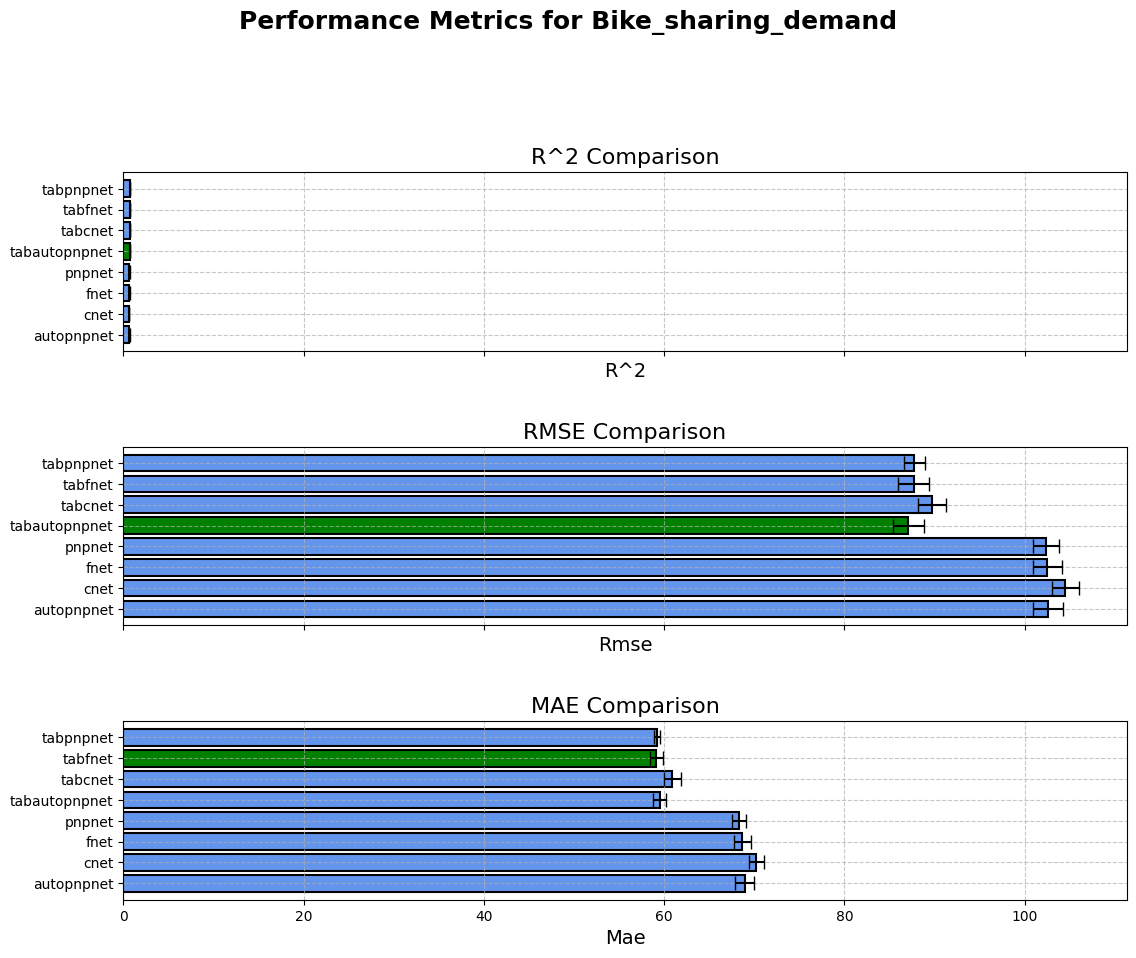

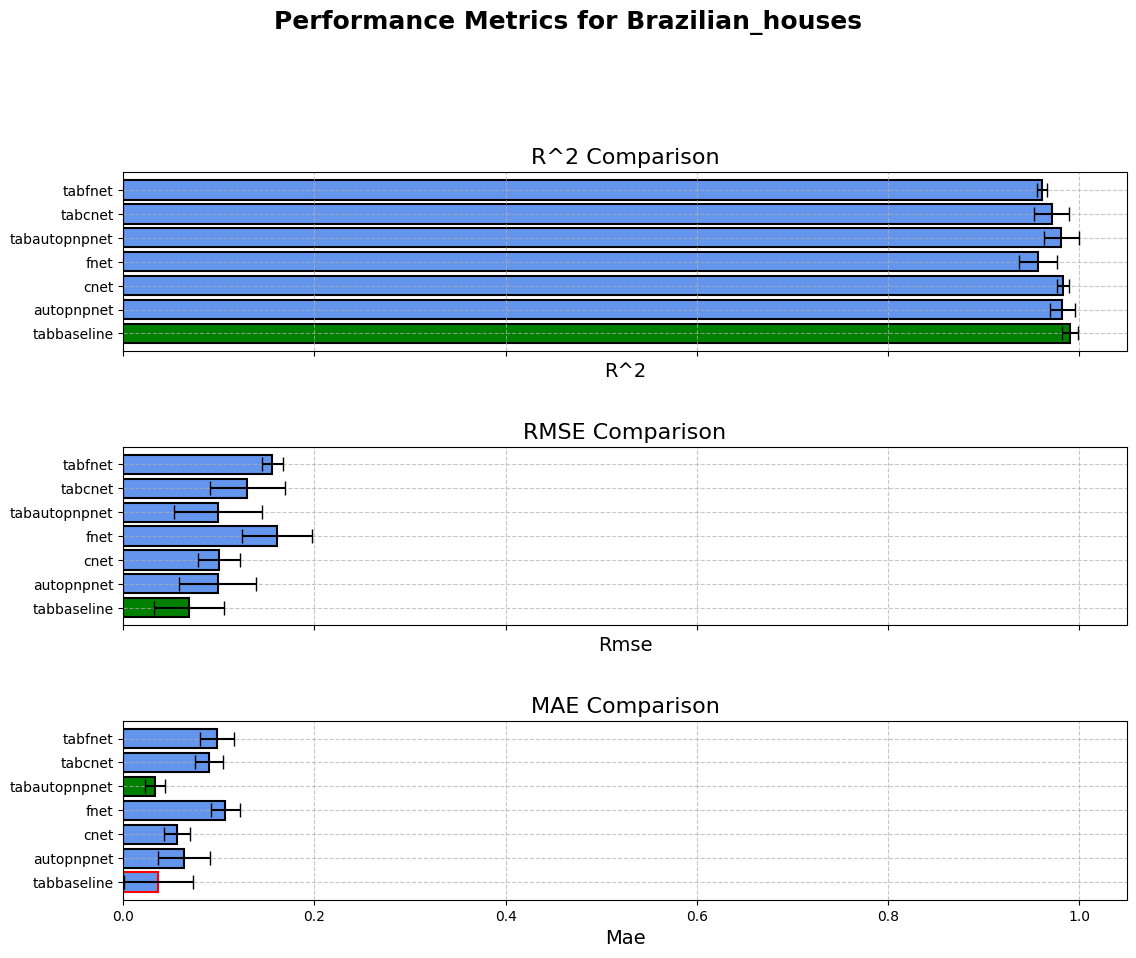

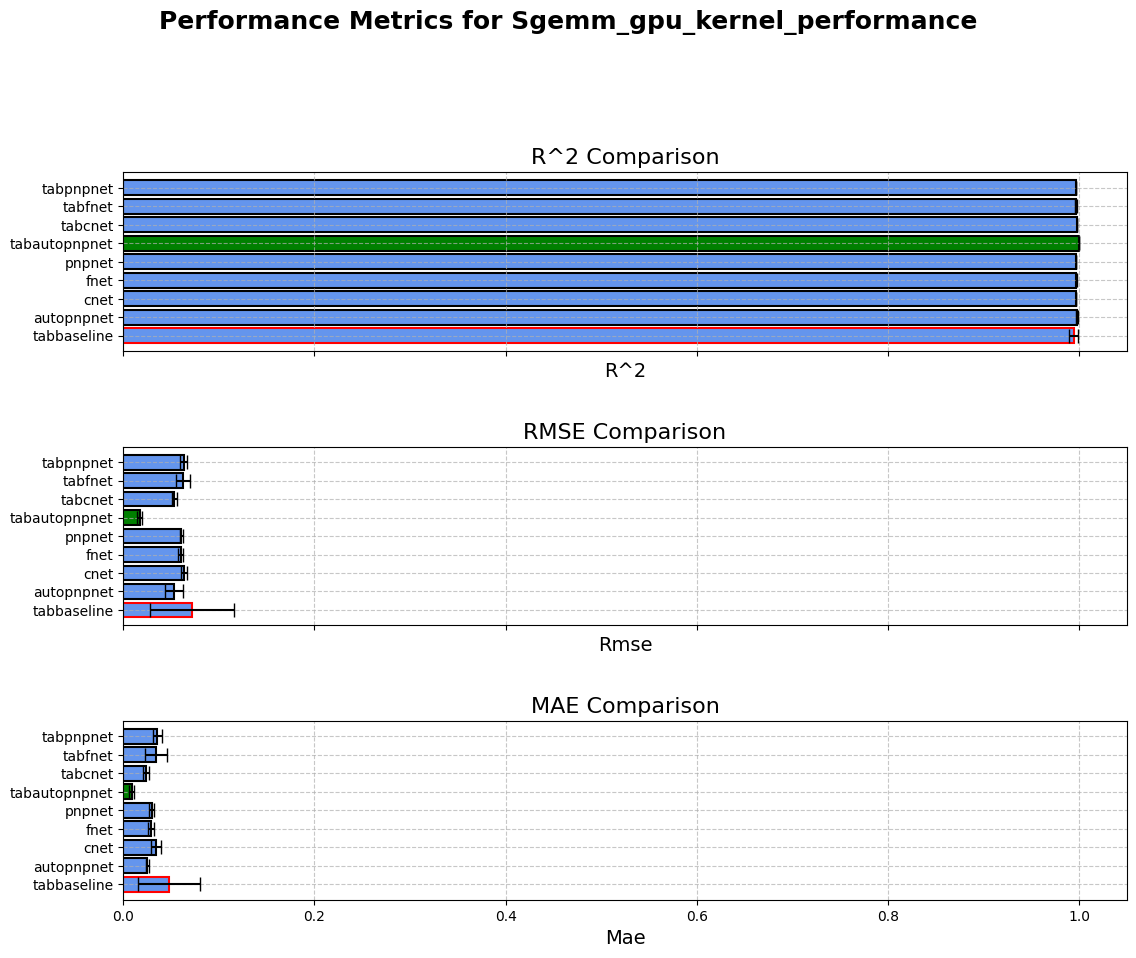

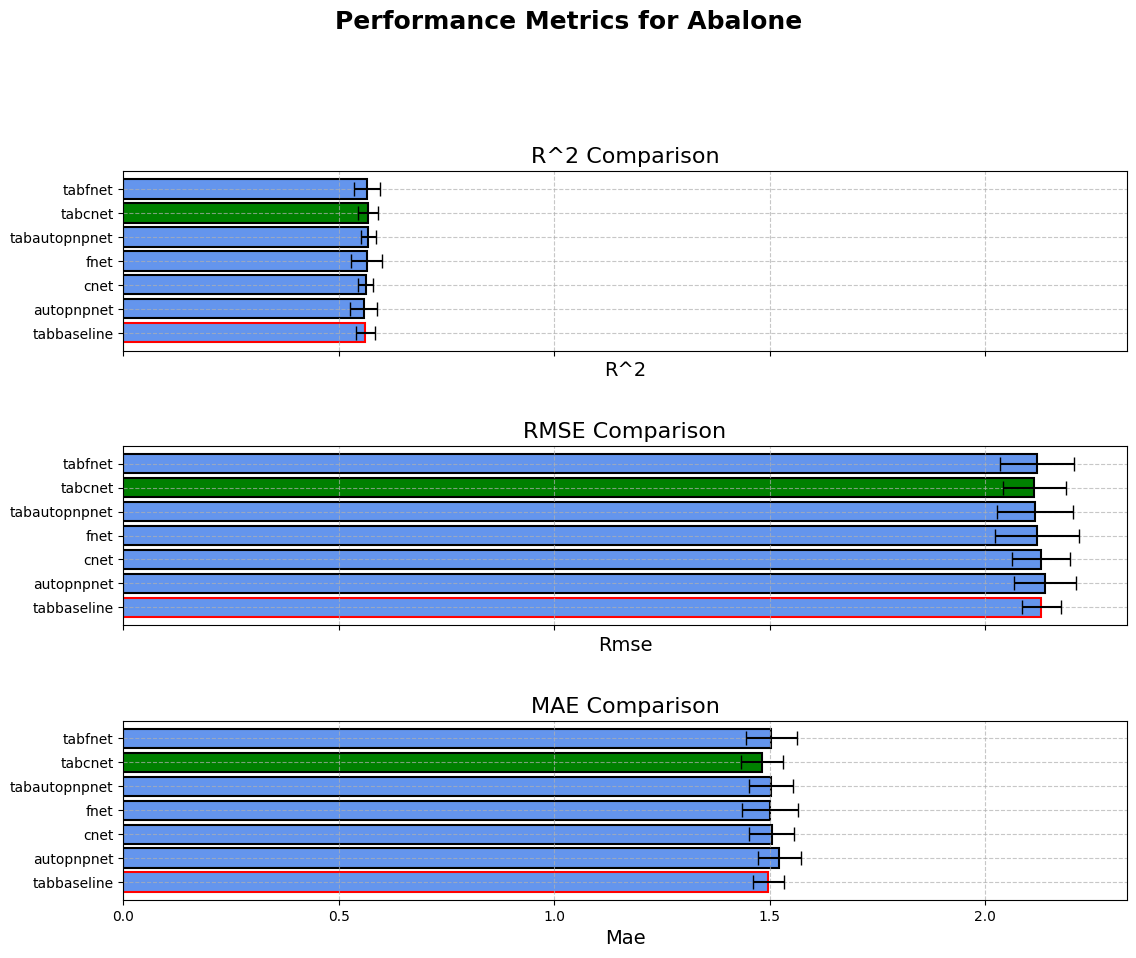

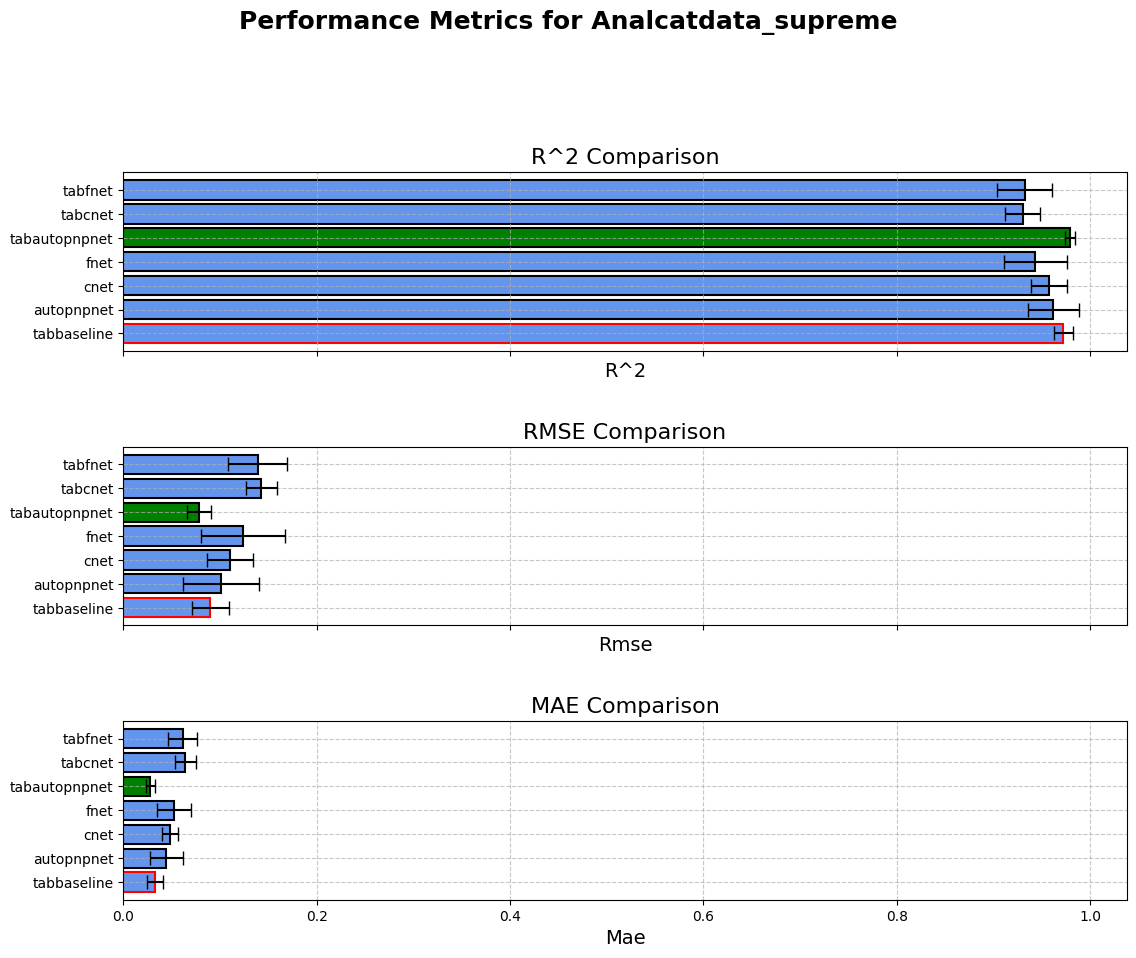

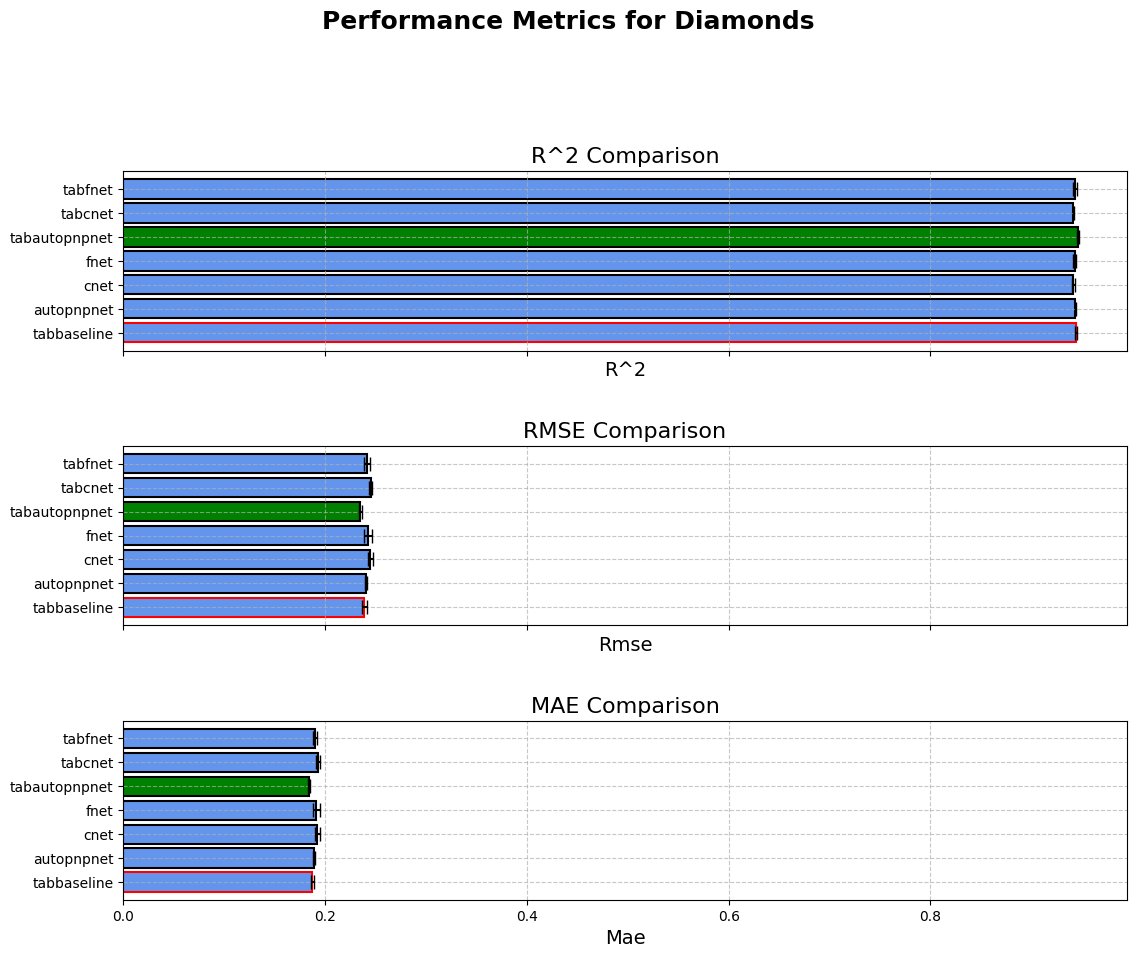

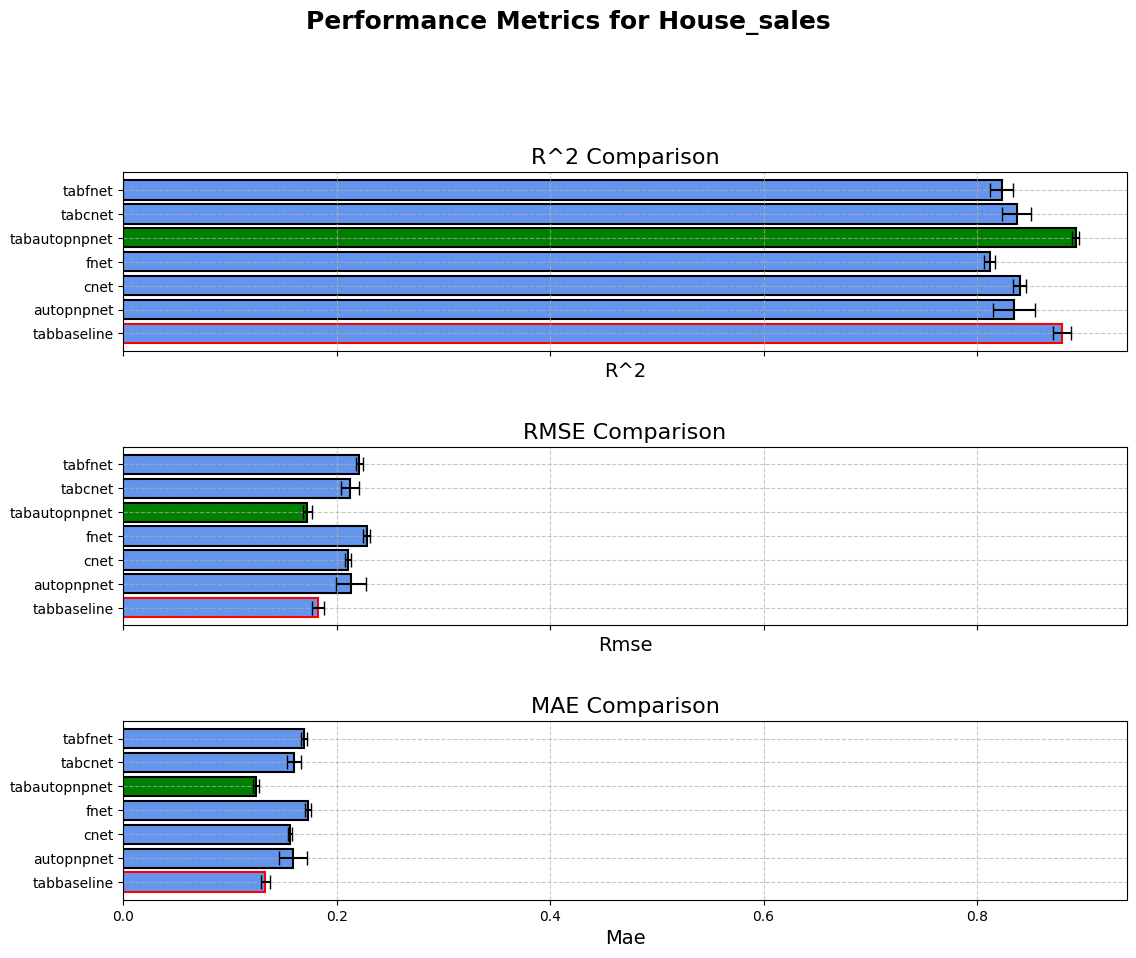

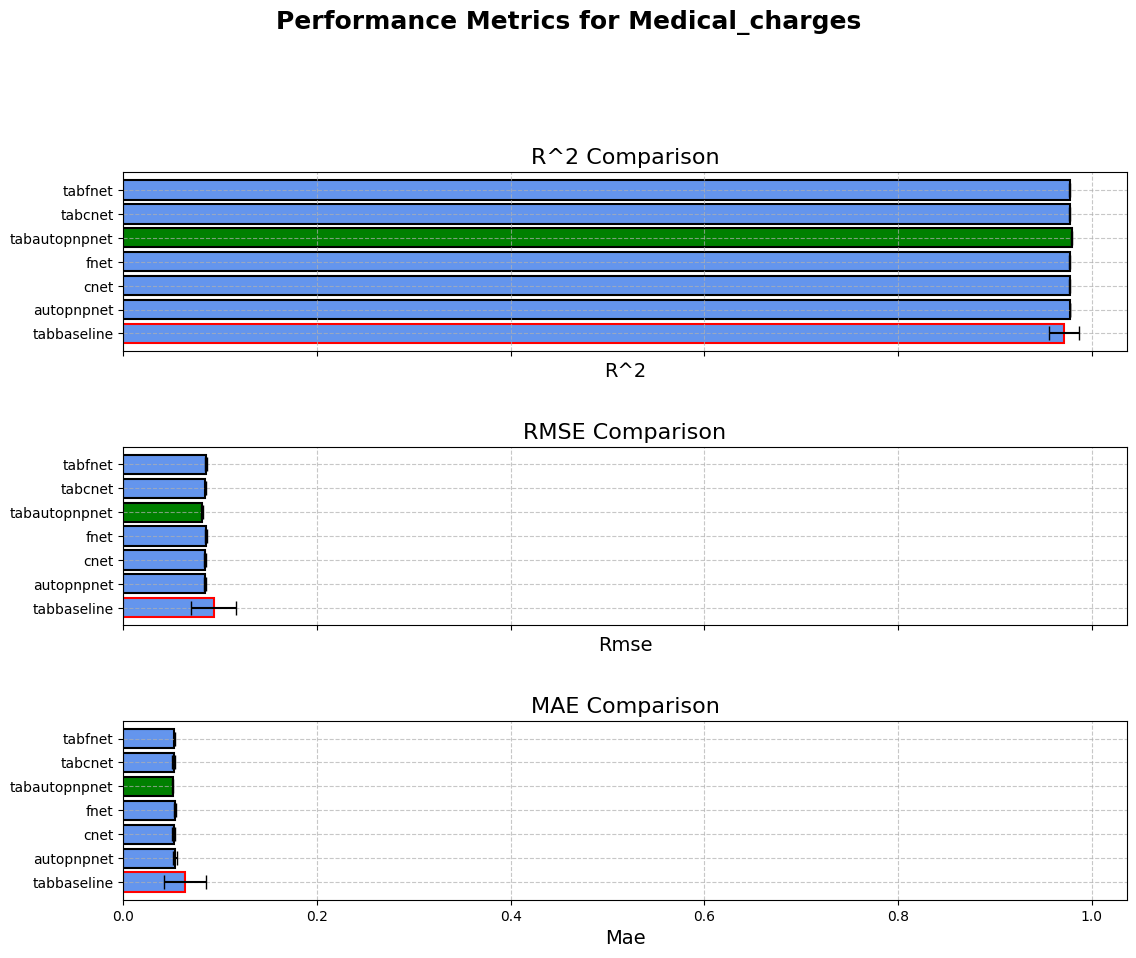

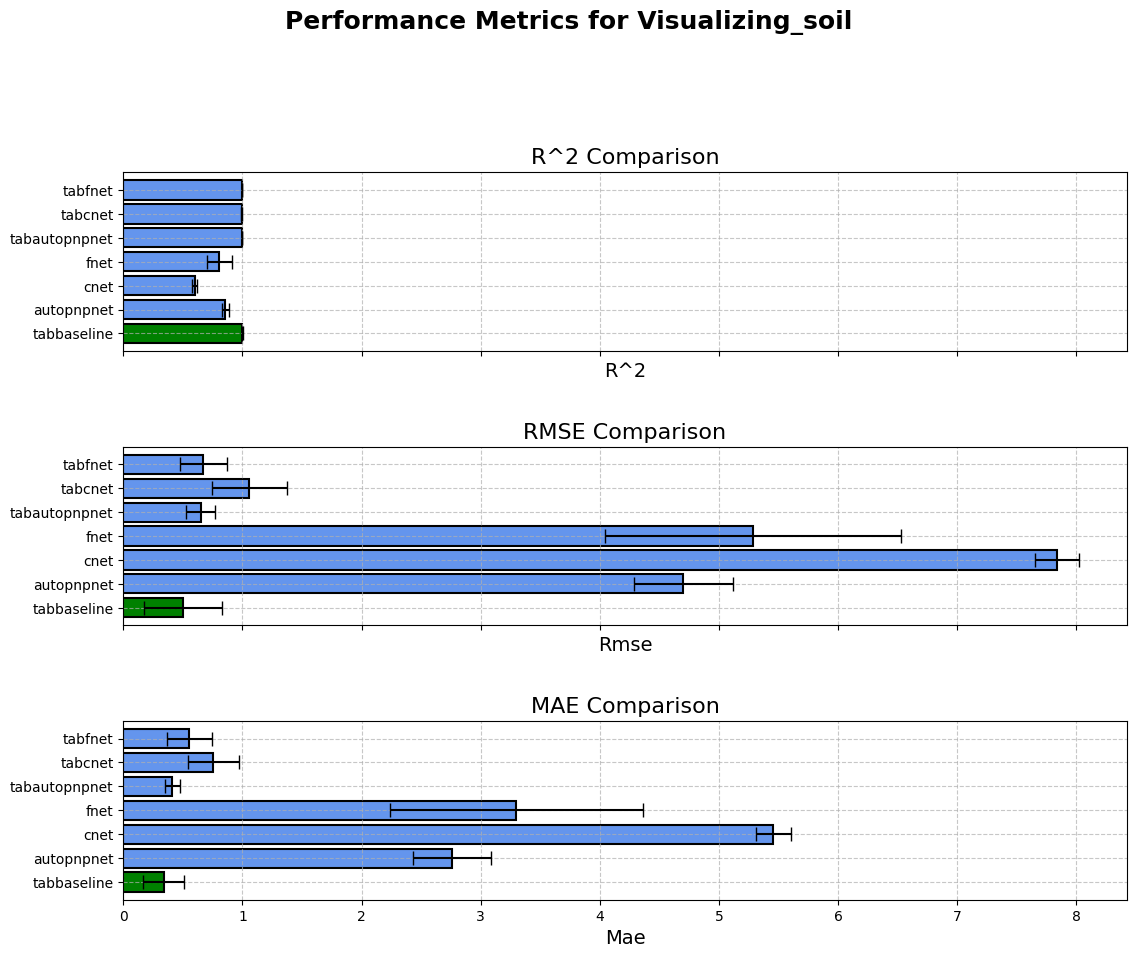

In [4]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

# Define the path to the directory containing experiment logs
LOG_DIR = "../results/benchmark_cat_reg"

def load_metrics(json_path):
    """Load and return metrics from a JSON file, handling exceptions gracefully."""
    try:
        with open(json_path, 'r') as f:
            return json.load(f)
    except (json.JSONDecodeError, FileNotFoundError) as e:
        print(f"Error loading {json_path}: {e}")
        return {}

def aggregate_metrics(log_dir):
    """Aggregate metrics from all experiment folders."""
    summary = []

    for folder in glob(f"{log_dir}/*__*"):
        dataset, model = os.path.basename(folder).split("__", 1)
        model = model.split("_")[0]

        # Load metrics for each fold in the dataset/model folder
        fold_metrics = [load_metrics(file) for file in glob(f"{folder}/*_metrics.json")]
        fold_metrics = [fm for fm in fold_metrics if fm]  # Filter out any empty dicts

        if fold_metrics:
            metrics_df = pd.DataFrame(fold_metrics)
            avg_metrics = metrics_df.mean().to_dict()
            std_metrics = metrics_df.std().to_dict()
            avg_metrics.update({"dataset": dataset, "model": model})
            std_metrics.update({"dataset": dataset, "model": model})
            summary.append((avg_metrics, std_metrics))

    # Convert summaries to DataFrames
    avg_summary_df = pd.DataFrame([s[0] for s in summary])
    std_summary_df = pd.DataFrame([s[1] for s in summary])
    return avg_summary_df, std_summary_df

def calculate_percentage_improvement(best_value, baseline_value, metric):
    """Calculate the percentage improvement for a metric, accounting for direction of better values."""
    if baseline_value == 0:
        return None
    improvement = (best_value - baseline_value) / abs(baseline_value) * 100
    return improvement if metric == "R^2" else -improvement

def print_percentage_improvements(avg_summary_df, metrics=["R^2", "RMSE", "MAE"], baseline_model="tabbaseline"):
    """Print percentage improvements for each top-performing model relative to the baseline."""
    for dataset, data in avg_summary_df.groupby("dataset"):
        baseline_row = data[data["model"] == baseline_model]
        if baseline_row.empty:
            print(f"No baseline model data for dataset {dataset}")
            continue

        print(f"\nDataset: {dataset}")
        baseline_row = baseline_row.iloc[0]  # Single row, safe to use iloc[0] here
        for metric in metrics:
            baseline_value = baseline_row[metric]
            best_row = data.loc[data[metric].idxmax() if metric == "R^2" else data[metric].idxmin()]
            best_model, best_value = best_row["model"], best_row[metric]

            if best_model != baseline_model:
                improvement = calculate_percentage_improvement(best_value, baseline_value, metric)
                print(f"  {metric} - {best_model} improvement over {baseline_model}: {improvement:.2f}%")

def get_colors_and_edges(models, best_idx, highlight_model="tabbaseline"):
    """Assign colors and edge colors for models, highlighting best and baseline models."""
    colors, edges = [], []
    for idx, model in enumerate(models):
        if idx == best_idx:
            colors.append('green')  # Highlight best model
            edges.append('black')
        elif model == highlight_model:
            colors.append('cornflowerblue')  # Regular color for "tabbaseline"
            edges.append('red')  # Red edges for baseline
        else:
            colors.append('cornflowerblue')
            edges.append('black')
    return colors, edges

def plot_metrics_per_dataset(avg_summary_df, std_summary_df):
    """Plot R^2, RMSE, and MAE metrics with error bars for each dataset."""
    metrics = ["R^2", "RMSE", "MAE"]

    for dataset, data in avg_summary_df.groupby("dataset"):
        std_data = std_summary_df[std_summary_df["dataset"] == dataset]
        data = data.set_index("model").loc[sorted(data["model"], key=lambda x: (x != "tabbaseline", x))].reset_index()
        std_data = std_data.set_index("model").loc[data["model"]].reset_index()

        fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 10), sharex=True)
        fig.suptitle(f"Performance Metrics for {dataset.capitalize()}", fontsize=18, weight='bold')

        for i, metric in enumerate(metrics):
            ax = axes[i]
            values, errors = data[metric], std_data[metric]
            models = data["model"]
            best_idx = values.idxmax() if metric == "R^2" else values.idxmin()
            colors, edges = get_colors_and_edges(models, best_idx)

            ax.barh(models, values, xerr=errors, color=colors, edgecolor=edges, capsize=5, linewidth=1.5)
            ax.set_title(f"{metric.upper()} Comparison", fontsize=16)
            ax.set_xlabel(metric.capitalize(), fontsize=14)
            ax.grid(True, linestyle='--', alpha=0.7)

        plt.tight_layout(pad=3.0, rect=[0, 0, 1, 0.95])
        plt.show()

def count_top_models(avg_summary_df, metrics=["R^2", "RMSE", "MAE"], baseline_model="tabbaseline"):
    """Count top-performing models across datasets, excluding the baseline model."""
    top_counts = {metric: {} for metric in metrics}
    total_datasets = avg_summary_df["dataset"].nunique()

    for dataset, data in avg_summary_df.groupby("dataset"):
        for metric in metrics:
            best_model = data.loc[data[metric].idxmax() if metric == "R^2" else data[metric].idxmin()]["model"]
            if best_model != baseline_model:
                top_counts[metric].setdefault(best_model, 0)
                top_counts[metric][best_model] += 1

    # Calculate totals per metric
    totals = {metric: sum(counts.values()) for metric, counts in top_counts.items()}
    return top_counts, totals, total_datasets

# Run the analysis
avg_summary_df, std_summary_df = aggregate_metrics(LOG_DIR)
print("Aggregated Results (Averages):")
print(avg_summary_df)

# Count top models
top_counts, totals, total_datasets = count_top_models(avg_summary_df)
print("\nNon-baseline models achieving top performance per metric:")
for metric, counts in top_counts.items():
    print(f"\n{metric}:")
    for model, count in counts.items():
        print(f"  {model}: {count}/{total_datasets} datasets")
    print(f"  Total non-baseline top performers for {metric}: {totals[metric]}/{total_datasets} datasets")

# Print percentage improvements
print("\nPercentage improvements of top-performing models relative to the baseline:")
print_percentage_improvements(avg_summary_df)

# Save summaries
avg_summary_df.to_csv("experiment_summary_avg.csv", index=False)

# Plot metrics
plot_metrics_per_dataset(avg_summary_df, std_summary_df)
